In [1]:
import cv2
from face_detector import YoloDetector
from PIL import Image
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

/home/nigar/anaconda3/envs/yolov5/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YoloDetector(target_size=112,gpu=0,min_face=90)
orgimg = cv2.imread('matthew_mcconaughey.jpg')#np.array(Image.open('matthew.jpg'))
bboxes,points = model.predict(orgimg)

0
/home/nigar/Projects/face_aligner_on_yolov5/weights/yolov5n_state_dict.pt


In [3]:
for box,lm in zip(bboxes,points):
    x1,y1,x2,y2 = box[0]
    # orgimg = cv2.rectangle(orgimg,(x1,y1),(x2,y2),(255,0,0),3)
    for i in lm[0]:
        x = i[0]
        y = i[1]
        orgimg = cv2.circle(orgimg, (x, y), 3, (0,255,0), -1)
# bboxes = bboxes[0]
lm = lm[0]

In [4]:
#finding distances between two points:
def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

In [5]:
# center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
roll_score = np.arctan((lm[0][1]-lm[1][1])/(lm[0][0]-lm[1][0]))
left_eye, right_eye = lm[0], lm[1]
nose = lm[2]
center_of_eyes = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

# alpha = 60./180*math.pi
# dx = right_eye[0] - left_eye[0]
# dy = right_eye[1] - left_eye[1]
# xp = left_eye[0] + math.cos(alpha)*dx + math.sin(alpha)*dy
# yp = left_eye[1] + math.sin(-alpha)*dx + math.cos(alpha)*dy
# center_of_forehead = [xp, yp]
center_of_forehead = (int((x1+x2) / 2), int((y1+y1)/2))


[[252, 165], [345, 128], [339, 200], [299, 266], [380, 235]]

In [6]:
length_line1 = distance(center_of_eyes, nose) #the median
length_line2 = distance(center_of_forehead, nose)  #lines for finding angles between
length_line3 = distance(center_of_forehead, center_of_eyes)

In [7]:
def cosine_formula(length_line1, length_line2, length_line3):
    cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
    return cos_a

In [8]:
#retrieving the angle in radians:
cos_a = cosine_formula(length_line1, length_line2, length_line3)
angle = np.arccos(cos_a)

In [9]:
#methods for rotation:
def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

In [10]:
#rotating:
rotated_point = rotate_point(nose, center_of_eyes, angle)
rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
if is_between(nose, center_of_eyes, center_of_forehead, rotated_point):
    angle = np.degrees(-angle)
else:
    angle = np.degrees(angle)

In [11]:
orgimg = Image.fromarray(orgimg)
aligned_img = np.array(orgimg.rotate(angle))

In [12]:
bboxes,points = model.predict(aligned_img)
for box,lm in zip(bboxes,points):
    x1,y1,x2,y2 = box[0]
    # orgimg = cv2.rectangle(orgimg,(x1,y1),(x2,y2),(255,0,0),3)
    for i in lm[0]:
        x = i[0]
        y = i[1]
        aligned_img = cv2.circle(aligned_img, (x, y), 5, (0,255,0), -1)
lm = lm[0]
new_roll_score = np.arctan((lm[0][1]-lm[1][1])/(lm[0][0]-lm[1][0]))

In [13]:
orgimg = np.array(orgimg)

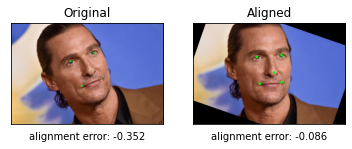

In [14]:
plt.subplot(1,2,1)
plt.title('Original')
plt.xlabel(f"alignment error: {roll_score:.3f}")
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(orgimg, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('Aligned')
plt.xlabel(f"alignment error: {new_roll_score:.3f}")
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
plt.savefig('matthewmcconaughey.png')

In [2]:
# from yolo_face_align import Yolo_align
# import cv2
# from matplotlib import pyplot as plt
# aligner = Yolo_align()
# original_img=cv2.imread('5ZHHAEQ.jpg')
# aligner.rotate(original_img)

<Figure size 432x288 with 0 Axes>